# Goal of the project

The goal of this project is to control a 2D quadrotor to reach a target while avoiding obstacles using a learned policy. You wil have to create your own Custom environment using the [stable_baselines3](https://stable-baselines3.readthedocs.io/en/master/) library and train a RL agent using PPO.

## 2D quadrotor

The quadrotor is depicted in the following figure
<img src='quadrotor.png' width="300">


The quadrotor model is written as
$$\begin{align} 
\dot{p_x} &= v_x\\
m \dot{v}_x &= - (u_1 + u_2) \sin \theta \\ 
\dot{p_y} &= v_y\\
m \dot{v}_y &= (u_1 + u_2) \cos \theta  - m g\\
\dot{\theta} &= \omega\\
I \dot{\omega} &= r (u_1 - u_2) \end{align}$$
where $p_x$ is the horizontal and $p_y$ the vertical positions of the quadrotor and $\theta$ is its orientation with respect to the horizontal plane. $v_x$ and $v_y$ are the linear velocities and $\omega$ is the angular velocity of the robot. $u_1$ and $u_2$ are the forces produced by the rotors (our control inputs). $m$ is the quadrotor mass, $I$ its moment of inertia (a scalar), $r$ is the distance from the center of the robot frame to the propellers and $g$ is the gravity constant. To denote the entire state, we will write $x = [p_x, v_x, p_y, v_y, \theta, \omega]^T$ - we will also write $u = [u_1, u_2]^T$.

The module ```quadrotor.py``` defines the problem and provides all the useful information about the robot and methods to simulate and animate it as shown below.

You can access the different parameters of the model in the following way:

In [1]:
import quadrotor

print("Mass    =", quadrotor.MASS)
print("Length  =", quadrotor.LENGTH)
print("Inertia =", quadrotor.INERTIA)
print("Dt      =", quadrotor.DT)
print("state size   =", quadrotor.DIM_STATE)
print("control size =", quadrotor.DIM_CONTROL)

Mass    = 0.5
Length  = 0.15
Inertia = 0.1
Dt      = 0.04
state size   = 6
control size = 2


The goal of this project is to learn a policy that can move the robot from any point to the red dot ($x^{\star} = [2, 0, 0, 0, 0, 0]^T$) while avoiding thee obstacles. The obstacles are represented by the black circles in the animation. You can check if the drone is in collision with an obstacle using the function ```quadrotor.check_collision```. 

## Create a RL environment
Using the [stable_baselines3](https://stable-baselines3.readthedocs.io/en/master/), create a [custom RL environment](https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html) environment. You will have to follow the following steps:

1. Implement a step function than contrains the dynamics (you are free to use the ```quadrotor.next_state```) and a reward function. To speed-up the training, make sure to add a gravity compensation term in your dynamics (i.e. the drone should stay in place when the policy outputs zeros).
   The reward should be made of three terms:
   
- A positive term to incentivize the quadrotor to reach the target. You can start with a reward bounded between 0 and 1, e.g.
   $\operatorname{exp}(-\frac{1}{2} (x - x^{\star})Q(x - x^{\star}) -\frac{1}{2} (u - u_{\text{gravity}})R(u - u_{\text{gravity}}))$

   
- A large negative penality(e.g. -100)  if the robot get out of the following bounds:
$ p_x \in [-4, 4], \quad v_x \in [-10, 10] , \quad p_y \in [-4, 4] , \quad v_y \in [-10, 10] , \quad \theta \in [-2 \pi, 2 \pi] , \quad \omega \in [-10, 10] $.

 - A negative penalty if the robot hits the obstacle, e.g. -1. You should use the ```quadrotor.check_collision```.

Keep in mind that, in RL, the goal is to maximize a reward (and not minimize a cost like in Optimal Control).

2. Implement a reset function that initializes the state randomly. You can sample uniformly between $[-2, 2]$ for $p_x$ and $p_y$ and initialize the other terms to zero. Make sure to reject samples that are colliding with the obstacles using the ```quadrotor.check_collision```.

3. In the step function, stop the environment using ```truncated``` after 200 steps (Here is an [example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb)).

4. In the step function, stop the environment if the drone goes outsite of the provided bounds using ```terminated``` (Here is an [example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb)).

5. Make sure that your environment is well defined using the ```check_env``` function.
   
## Training a policy with PPO   
Train a policy with PPO and use the learned policy to define a controller. Make sure that you can reach the target while avoiding the obstacles starting from $x_0 = [-2, 0, 0, 0 ,0, 0]$



Please submit your code (as runnable Jupyter Notebook), a pdf report and an mp4 video. In the report, explain your reward design and provide plots showing the trajectory of the quadrotor. The mp4 video should show the quadrotor animation starting from $x_0 = [-2, 0, 0, 0 ,0, 0]$. You can save your animation in the following way:


In [2]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import IPython
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.env_checker import check_env

import quadrotor

# Define numpy manual seed
np.random.seed(2109)

def controller(x, t):
    return np.zeros(2)

x_init = np.array([-2., 0., 0., 0., 0., 0.])
des_state = np.array([2., 0., 0., 0., 0., 0.])
horizon_length = 200
t, state, u = quadrotor.simulate(x_init, controller, horizon_length)
reward = 0
# quadrotor.animate_robot(state, u, save_mp4=False)

In [3]:
# Define the quadtor model parameters
dt = quadrotor.DT
xdim = quadrotor.DIM_STATE
udim = quadrotor.DIM_CONTROL
mass = quadrotor.MASS
r = quadrotor.LENGTH
I = quadrotor.INERTIA
g = quadrotor.GRAVITY_CONSTANT

# Define the initial state
x_init = np.array([-2, 0, 0, 0 ,0, 0])

# Define the desired state
des_state = np.array([2, 0, 0, 0 ,0, 0])

# Define the horizon length
horizon_length = 200

# Define the bounds as specified in the problem
max_state = np.array([4, 10, 4, 10, 2*np.pi, 10])
min_state = np.array([-4, -10, -4, -10, -2*np.pi, -10])

# Define the final hover control
hover_control = np.array([.5*mass*g, .5*mass*g])

# Define the Cost Matrix
Q = np.zeros((xdim, xdim))
Q[0, 0] = Q[2, 2] = 10
Q[1, 1] = Q[3, 3] = Q[4, 4] = Q[5, 5] = 0.1

# Define the Control Cost
R = np.eye(udim) * 0.5


In [4]:
class ObstacleAvoidance(gym.Env):
    """Custom Environment that follows gym interface."""

    metadata = {"render_modes": ["human"], "render.fps": 30}

    def __init__(self):
        super(ObstacleAvoidance, self).__init__()
        
        # Define action space
        self.action_space =  spaces.Box(low=np.array([-10,-10]), high=np.array([10,10]), shape=(2,), dtype=np.float32)
        
        # Define observation space
        self.observation_space =  spaces.Box(low=min_state, high=max_state, shape=(6,), dtype=np.float32)

        #Initial State
        self.state = x_init
        self.current_step =0
        

    def step(self, action):
        
        # Call the next state of the quadrotor  
        self.state = quadrotor.next_state(self.state, action)
        
        # Define the reward function and obtain the reward
        reward = np.exp(-.5*(self.state-des_state)@Q@(self.state-des_state)-.5*(action-hover_control)@R@(action-hover_control))

        # Check if the state is within the bounds
        if any(self.state > max_state) or any(self.state < min_state):
            reward -= 100
            terminated = True
        else:
            terminated = False

        # Penalize if the quadrotor collides with the obstacle
        if quadrotor.check_collision(self.state) == True:
            reward -= 1

        # Incerement the step counter
        self.current_step += 1

        # Check if the episode is done
        truncated = self.current_step >= 200

        # Optional: add extra info
        info = {}
    
        return (np.array(self.state).astype(np.float32),reward,terminated,truncated,info)

    def reset(self, seed=2109, options=None):
        # Reset the state of the environment to a random initial state
        pos = np.random.uniform(-2, 2, 2)
        self.state = np.array([pos[0], 0, pos[1], 0, 0, 0])

        # If collision is detected, reinitialize the state
        while quadrotor.check_collision(self.state) == True:
            pos = np.random.uniform(-2, 2, 2)
            self.state = np.array([pos[0], 0, pos[1], 0, 0, 0])

        #reset step counter
        self.current_step =0
        
        return np.array(self.state).astype(np.float32), {}  # empty info dict

    def render(self):
        ...

    def close(self):
        ...

In [5]:
# Check the environment
env = ObstacleAvoidance()
check_env(env, warn=True)

/home/river2000/.local/lib/python3.10/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/river2000/.local/lib/python3.10/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(
/home/river2000/.local/lib/python3.10/site-packages/stable_baselines3/common/env_checker.py:461: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [6]:
# Instantiate the environment
vec_env = make_vec_env(ObstacleAvoidance, n_envs=1)

# Train the agent
model = PPO("MlpPolicy", vec_env, verbose = 1, device='cpu').learn(total_timesteps = 1000000)

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23       |
|    ep_rew_mean     | -101     |
| time/              |          |
|    fps             | 1373     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 23.2        |
|    ep_rew_mean          | -101        |
| time/                   |             |
|    fps                  | 1106        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.003882208 |
|    clip_fraction        | 0.0202      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.84       |
|    explained_variance   | -0.0188     |
|    learning

In [7]:
#Test model on quadrotor sim 
obs, _ = env.reset()
x_array =[]
u_array =[]
def controller(x, t):
    action, _ = model.predict(x, deterministic=True)
    x_array.append(x)
    u_array.append(action)
    return action


horizon_length = 200
t, state, u = quadrotor.simulate(x_init, controller, horizon_length)
quadrotor.animate_robot(state, u, save_mp4=False)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAeHFtZGF0AAACrwYF//+r
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyByMzA2MCA1ZGI2YWE2IC0gSC4yNjQvTVBF
Ry00IEFWQyBjb2RlYyAtIENvcHlsZWZ0IDIwMDMtMjAyMSAtIGh0dHA6Ly93d3cudmlkZW9sYW4u
b3JnL3gyNjQuaHRtbCAtIG9wdGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFs
eXNlPTB4MzoweDExMyBtZT1oZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVk
X3JlZj0xIG1lX3JhbmdlPTE2IGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBk
ZWFkem9uZT0yMSwxMSBmYXN0X3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTI0
IGxvb2thaGVhZF90aHJlYWRzPTQgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50
ZXJsYWNlZD0wIGJsdXJheV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBi
X3B5cmFtaWQ9MiBiX2FkYXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29w
PTAgd2VpZ2h0cD0yIGtleWludD0yNTAga2V5aW50X21pbj0yNSBzY2VuZWN1dD00MCBpbnRyYV9y
ZWZyZXNoPTAgcmNfbG9va2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0w
LjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA
GohliIQAO//+906/AptFl2oDklcK9sqkJlm5UmsB8qYAAAMAAAMAAAMAABH5cLAuyiEuZJAAAAMA
EzAC3gGqAVYBhT85A0T90eABESP3ATZBsfRWYYKQyH9FYaJhZgC0iWFFh63kMmX7s+0cydB2uiLg
m6NdUr25H+5q/UOrkKsunbzfT9JNmcVIqGu2KgKQ8H07JVOfCdPgyVGNKPlr+M+J41iyL+P7iLKa
LX57COL4/tZXe9o+kP3nhBzjaPp2Ye6fLqRDNKToI0+s4whCIYEU169/Sjd4xrERBBt1j/YiKoTK
XIODL7n5FHGGPl1pQ7tzPGmH3OZvOkVXv0Vj2cr8mXHFl8mMr69WUyGfZHW/f0L75r0DSWqw1h2O
vJKOpQ9P8FecMCCYNd87riOmLIicnHsBMdqrymIhd8zqTyBSQ/pHnV3M22/6j8nr/CzzxB7c42BR
aqfsCisz4sCaS28DFytPt6Y/JixzaQPceIXKg+8AF3VZ3CpIu9YAlvlnXske2obryrrIiSvziYtq
9xvi0R3TvRrRv1mzOMZ8C1Cu9EPUb2sxSkg1soFJwxZIpB4Yq1oF4pycePau7PH78W9qx+Ia2FnK
qvIXJ9LKaJRRckMQCIWfl6hom0dBfpYN1FPGFo+K+482gZZGA63h7lFH/tjP04PWpQ5rgeR2KJ+1
beJHI0oS0Rc7xn5ESGrMlINd8JC05vY1cOoFwly1f1TjvS20f8MUlgfSGl/wYgsYL+o7GUBG8xFs
7v4g2ks3UCbVAguwzrw/1rdFtkZ0McRB3hZr/5fknJz9O5De18BxFmIw3M7HmP3OL0k0UfeSedP4
IK37QYYlobn1lj2bDGHzsiEv453G5wiNHogNMoZVT7Z/svcTCNbnMz8piLuXfKibCi4Wh8YiDfZ8
JQMFvgT0hbAUAB5h9pUS6cQ+h4u+JkHZUpnwYY6Y+RyCdVGl9hbkBAAARTN/wXmxZeIZWycquyA+
R28ItqZ06IMd/gO1hherqS9VhXqdQnxEHb/Ljkch6eC3c80LOi1Pcmv9fhmp1dCBD7byACInrzfy
J5PsgMXkXCpbjTohhEusKyH1lUoJiQrTx+Tq0BGx6wMvpOSSD0jAeOWbcaW92N2/pdK/Up/0N46b
yB6eh/Le/ZL0LimN8E9Yy3SIetNAfucB3QXfJxytuP3Y5k6YnEgNP5DriegvLFPUhv6nWoEzR6LL
DKWQhrEnsIucf+411dcwdVVQAAHOE+NqzgdLgJIWxqdriwWIiNzcxXEg4ulV1zVd86Di38tbuU7U
00XgWDSh7a6m1NiotoiROBh44rYrExUF6AGgR38T45lVPLaaV5LPVgN2RCd98vBJdQef8Hqy0mq0
PBs00yaqRu5a12/BMoPgaQabOLoUpFrIZzW7a3FJ6dRNtX2HZg1rBJQVih1QAYSVC6vRWsFEGqye
udkZwuo3CNu/hW4mrM74h2DmMDxOQKagUC1T8EjgeuGBrEfum03ra/ZbsFsLx+rZ/xMDnudz1DE/
mHD/uDMNfEqun6iENgPG+nEJsbEe4h2+Q0cWySmRwQ28qy500biiMQ/TW7OJED+zjA+LejV4UTc8
Wp4UUr++VG0++ViQSk+fmY1QnVWRj+nfnadBq77yX+/xW3tnAOUbFm7v8FcvPENGT2ZXNbzqQaqh
Fl+AMMu64YL47PQjWAELM6Y8XMAAy+eEpJvNWUyay0XlttDz+9sHxEo/oFV308cJW2nVDSmHDlIn
xMILC78TPQ88/4lliVJUPnAEK2wT7zgpF9p3HsRxaq6b1o+r5vpYvFcixfSphRa2LcpCrmw+PXGi
dbjAn9ALyt+DBO01z3HGBcuT8OFjuiMjimAfTHaMH1CzQBfE44+w9sDnNUfVqwBmQLC7XDkDb3xo
iiQrk8AgVCVzlckZLaB8IYJV07GxJP5qbTRv3XKbV2b6YB9mkdkuGGvncRCcv4VnFWAHLqxnahNH
e2XlWEvHpWn7YZlBjjkq2VTahlaW42ZsHfdlRX/LiMe9m69p/LgkyYgQxh7FVEx7rYIyHhFAAhoE
fgY8b3NL8rT/R1NaVijOaV+YCjn+AzSBI/dSqRbHY2gGLTx18/PLyXGfEQ8EqLLKeBeffUVFHsyh
HxA+tvJdgNijAaykj81tlmcCQIRBrAmrh1ZaKNoGBNOEY5dGkkiQNWNlDMBXuMqBcwjquJZHt/k4
ECbZmHvXtqKTINALddUkvuP/RHHNmj2AAUN6qdS7GmWSHzmzBQM77WaPcJbrrHvCKYOWX1jpZe1k
O0oAvD8/mVl1Nrsfvk/nvs4VkVLh5EWirtDt6el5O2ixkV0PCDAC6bSDIRxz9sBcS32h3YPMJsqM
KXAYd2iG3/t+AAL74cP6KnDKi1OBTLFHx+6BQjWo6bJ+H7+KsNLYViitEzfHdvwdC9v+GvHxh+UV
xRBRqFLklxkTLdcaBsmkZLTrlBF6vm9mmrbo6hQ53SZ49fgl0ZcNRTeIs5+WSfsNFj0Dvw5RmS9d
P7rXDS3KRu1jes1fWyLQVYgGMGMb91nmw8PuwrW/mkx20r7+JyiOFVFb4jpzdb+OuCuq5MPYQBtF
h5Zz0b4qYL3ad/VDah1YCLt2idVLRfA10C8kt/zbOpbGcFSRTKQwuC2zNUg6JEVxwz+89jZW3dIZ
G/Q6SdPrCPxFV1kX8E5bKDvgr3AjbEPpo26iYaO/+T5M+iTF9NoLtTCUdW/xl9tsub8XDBlr4h48
ZB7mfF3n9xifpqrZK/aZ0IchWRs1tyNBn5YEuASXM2uL0k1E52mEllAmFfsNdCiM9g/pE+qm8G4U
4is/a2iDPBpIUQqSnXzdRbPNPPT/UH4claU0YPDcAAADAAWPXC8A8lyYMvyYB4Vij/JlThuSnYOb
NxYdsjSZiA/lZYkUkVhMi

In [ ]:
# Save the model
# model.save("ppo_quadrotor")

# Load the model from the file
model = PPO.load("ppo_quadrotor")

# Test the model
obs, _ = env.reset()
x_array =[]
u_array =[]
def controller(x, t):
    action, _ = model.predict(x, deterministic=True)
    x_array.append(x)
    u_array.append(action)
    return action


horizon_length = 200
t, state, u = quadrotor.simulate(x_init, controller, horizon_length)

quadrotor.animate_robot(state, u, save_mp4=True)


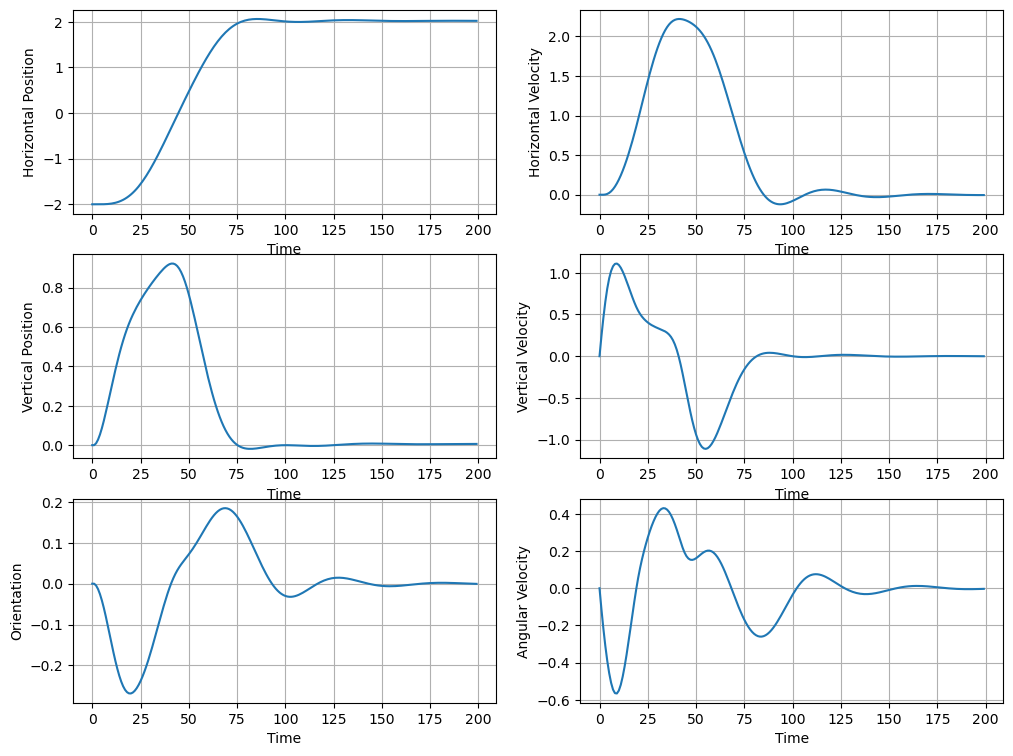

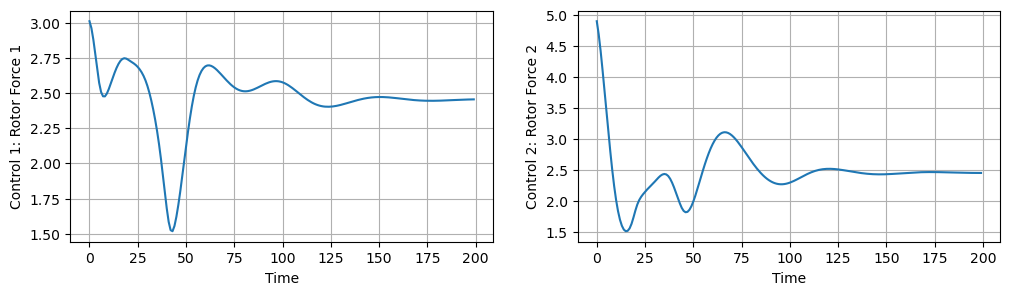

In [27]:
#Plot trajectory
x_array = np.array(x_array)
u_array = np.array(u_array)

plt.figure(figsize=[12,9])
plt.subplot(3,2,1)
plt.xlabel('Time')
plt.ylabel('Horizontal Position')
plt.plot(x_array[:,0])
plt.grid()
plt.subplot(3,2,2)
plt.xlabel('Time')
plt.ylabel('Horizontal Velocity')
plt.plot(x_array[:,1])
plt.grid()
plt.subplot(3,2,3)
plt.xlabel('Time')
plt.ylabel('Vertical Position')
plt.plot(x_array[:,2])
plt.grid()
plt.subplot(3,2,4)
plt.xlabel('Time')
plt.ylabel('Vertical Velocity')
plt.plot(x_array[:,3])
plt.grid()
plt.subplot(3,2,5)
plt.xlabel('Time')
plt.ylabel('Orientation')
plt.plot(x_array[:,4])
plt.grid()
plt.subplot(3,2,6)
plt.xlabel('Time')
plt.ylabel('Angular Velocity')
plt.plot(x_array[:,5])
plt.grid()

plt.figure(figsize=[12,3])
plt.subplot(1,2,1)
plt.plot(u_array[:,0])
plt.xlabel('Time')
plt.ylabel('Control 1: Rotor Force 1')
plt.grid()
plt.subplot(1,2,2)
plt.plot(u_array[:,1])
plt.xlabel('Time')
plt.ylabel('Control 2: Rotor Force 2')
plt.grid()

